# Demand Data - Exploratory Data Analysis & Cleaning

**Dataset:** UK Electricity Demand Data (2001 - 2025)

**Team:** CloudAikes

**Doel:** 
- Data verkennen en begrijpen
- Data cleaning volgens project requirements
- Patronen en correlaties ontdekken
- Voorbereiden voor modeling

---

## 1. Setup & Data Loading

Hier maken we gebruik van de imports van de data en de setup.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In onderstaande cell verzamelen we alle CSV-bestanden en sorteren we ze. Aan het einde concateneren we alle ingelezen dataframes uit loaden naar één dataframe df_raw en print het totaal aantal rijen. Zo hadden we 1 dataframe met elke CSV-bestand.

In [2]:
from pathlib import Path
import re

# Pas pad aan indien nodig
data_dir = Path('../data/demand')
if not data_dir.exists():
    data_dir = Path('../data/')
if not data_dir.exists():
    data_dir = Path('../data/demand/')

csv_files = sorted(data_dir.glob('*.csv'))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {data_dir.resolve()}")

loaded = []
print("✅ Files found:")
for f in csv_files:
    df_tmp = pd.read_csv(f)
    loaded.append((f.name, df_tmp))
    # Probeer jaartal uit bestandsnaam te halen en maak variable df_YYYY
    m = re.search(r'(\d{4})', f.stem)
    if m:
        year = m.group(1)
        var_name = f"df_{year}"
        globals()[var_name] = df_tmp
        print(f"  - {f.name} -> variable {var_name}: {len(df_tmp)} rows")
    else:
        print(f"  - {f.name}: {len(df_tmp)} rows (no year in filename)")

# Samengevoegd dataframe (gebruik df_raw of vervang later bestaande concat)
df_raw = pd.concat([t[1] for t in loaded], ignore_index=True)
print(f"\n✅ Total combined rows: {len(df_raw)}")

✅ Files found:
  - demanddata_2001.csv -> variable df_2001: 17520 rows
  - demanddata_2002.csv -> variable df_2002: 17520 rows
  - demanddata_2003.csv -> variable df_2003: 17520 rows
  - demanddata_2004.csv -> variable df_2004: 17568 rows
  - demanddata_2005.csv -> variable df_2005: 17520 rows
  - demanddata_2006.csv -> variable df_2006: 17520 rows
  - demanddata_2007.csv -> variable df_2007: 17520 rows
  - demanddata_2008.csv -> variable df_2008: 17568 rows
  - demanddata_2009.csv -> variable df_2009: 17520 rows
  - demanddata_2010.csv -> variable df_2010: 17520 rows
  - demanddata_2011.csv -> variable df_2011: 17520 rows
  - demanddata_2012.csv -> variable df_2012: 17568 rows
  - demanddata_2013.csv -> variable df_2013: 17520 rows
  - demanddata_2014.csv -> variable df_2014: 17520 rows
  - demanddata_2015.csv -> variable df_2015: 17520 rows
  - demanddata_2016.csv -> variable df_2016: 17568 rows
  - demanddata_2017.csv -> variable df_2017: 17520 rows
  - demanddata_2018.csv -> variab

Hier proberen we eerst een reeds aangemaakte samengevoegd dataframe te gebruiken. Daarna printen we de grootte van het resulterende dataframe met aantal rijen en kolommen. Het doel is om de dataframe df klaarzetten voor verdere EDA en snel de datum range te tonen.

In [3]:
import re
from pathlib import Path

# Prefer the already created df_raw (from the loader cell)
if 'df_raw' in globals():
    df = globals()['df_raw'].copy()
else:
    # Zoek globale dataframes zoals df_YYYY
    candidate_dfs = [v for k, v in globals().items() if re.match(r'^df_\d{4}$', k) and isinstance(v, pd.DataFrame)]
    if candidate_dfs:
        df = pd.concat(candidate_dfs, ignore_index=True)
    else:
        # Fallback: lees alle CSVs uit Data/Demand of ../data/demand
        data_dir = Path('Data/Demand')
        if not data_dir.exists():
            data_dir = Path('../data/demand')
        if not data_dir.exists():
            data_dir = Path('./data/demand')
        csv_files = sorted(data_dir.glob('*.csv'))
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in {data_dir.resolve()}")
        df_list = [pd.read_csv(f) for f in csv_files]
        df = pd.concat(df_list, ignore_index=True)

print(f"✅ Combined dataframe: {df.shape[0]} rows x {df.shape[1]} columns")

# Try to detect date column (settlement_date case-insensitive) and show range if possible
date_col = None
for c in df.columns:
    if 'settlement' in c.lower() and 'date' in c.lower():
        date_col = c
        break
if date_col is None:
    # fallback: any column name containing 'date'
    date_candidates = [c for c in df.columns if 'date' in c.lower()]
    date_col = date_candidates[0] if date_candidates else None

if date_col is not None:
    try:
        date_series = pd.to_datetime(df[date_col], errors='coerce')
        print(f"\nDate range: {date_series.min()} to {date_series.max()} (column: {date_col})")
    except Exception:
        print(f"\nDate column detected: {date_col} (could not convert to datetime for range)")
else:
    print("\nGeen date-kolom gevonden om datum-range te tonen.")


✅ Combined dataframe: 434014 rows x 22 columns

Date range: 2001-01-01 00:00:00 to 2025-10-03 00:00:00 (column: SETTLEMENT_DATE)


## 2. Initial Data Exploration

Eerst kijken we naar de ruwe data om te begrijpen wat we hebben.

In [4]:
# First look at the data
print("First 5 rows:")
display(df.head())

print("\nLast 5 rows:")
display(df.tail())

First 5 rows:


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,2001-01-01,1,38631,NaN,34060,NaN,NaN,NaN,NaN,0,...,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-01-01,2,39808,NaN,35370,NaN,NaN,NaN,NaN,0,...,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-01-01,3,40039,NaN,35680,NaN,NaN,NaN,NaN,0,...,1511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-01-01,4,39339,NaN,35029,NaN,NaN,NaN,NaN,0,...,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-01-01,5,38295,NaN,34047,NaN,NaN,NaN,NaN,0,...,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Last 5 rows:


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
434009,2025-10-03,44,25095,26540.0,23271,5343.0,6606.0,0.0,20993.0,0,...,507,580.0,409.0,231.0,0.0,-626.0,476.0,607.0,1424.0,499.0
434010,2025-10-03,45,23308,24743.0,21619,5268.0,6606.0,0.0,20993.0,0,...,-3,-245.0,443.0,135.0,0.0,-254.0,105.0,266.0,1399.0,496.0
434011,2025-10-03,46,22176,23499.0,20725,5192.0,6606.0,0.0,20993.0,0,...,-50,-321.0,435.0,99.0,0.0,-226.0,39.0,230.0,1386.0,504.0
434012,2025-10-03,47,20740,22457.0,19448,5271.0,6606.0,0.0,20993.0,0,...,-234,-220.0,-325.0,38.0,-11.0,179.0,-144.0,-196.0,743.0,505.0
434013,2025-10-03,48,19877,22013.0,18729,5350.0,6606.0,0.0,20993.0,0,...,-263,-212.0,-379.0,-36.0,-110.0,208.0,-162.0,-232.0,680.0,434.0


We merken dat de eerste data rijen in de tabel veel NaN values heeft wat wel logisch is want toen bestonden deze FLOW's nog niet. We zijn wel in de laatste 5 rows dat deze data wel ingevuld is. We gaan dus dit merken in de volgende cellen dat er veel NaN zullen zijn. 

In [5]:
# Data info
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434014 entries, 0 to 434013
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SETTLEMENT_DATE            434014 non-null  object 
 1   SETTLEMENT_PERIOD          434014 non-null  int64  
 2   ND                         434014 non-null  int64  
 3   TSD                        363886 non-null  float64
 4   ENGLAND_WALES_DEMAND       434014 non-null  int64  
 5   EMBEDDED_WIND_GENERATION   328846 non-null  float64
 6   EMBEDDED_WIND_CAPACITY     328846 non-null  float64
 7   EMBEDDED_SOLAR_GENERATION  293758 non-null  float64
 8   EMBEDDED_SOLAR_CAPACITY    293758 non-null  float64
 9   NON_BM_STOR                434014 non-null  int64  
 10  PUMP_STORAGE_PUMPING       434014 non-null  int64  
 11  SCOTTISH_TRANSFER          48334 non-null   float64
 12  IFA_FLOW                   434014 non-null  int64  
 13  IFA2_FLO

We zien dus dat er 434.014 aantal rijden zijn met 22 kolommen. Het gaat hier over 72.8MB. De settlement_date staat als object maar moet nog naar datetime geconverteerd worden. We hebben volledige kolommen maar ook grote missing kolommen zoals scottish_transfer met 48.334 non-null. We hebben ook een andere zoals de NSL_FLOW, ELECLINK_FLOW, VIKING_FLOW, GREENLINK_FLOW die 118.462 non-null hebben. 

Dus sommige kolommen ontbreken systematish grote dele van de dataset waarschijnlijk omdat die verbindingen of metingen pas later zijn gestart.

Andere kernvariabelen zoals ND (National Demand) en ENGLAND_WALES_DEMAND zijn dan wel compleet.

Datumkolom als object verhindert ons wel als we tijdreeksen gaan gebruiken dus deze zullen we moeten omzetten.

In [6]:
# Statistical summary
print("Statistical Summary:")
display(df.describe())

Statistical Summary:


,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,...,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
count,434014.000000,434014.000000,363886.000000,434014.000000,328846.000000,328846.000000,293758.000000,293758.000000,434014.000000,434014.000000,...,434014.000000,293758.000000,293758.000000,363886.000000,293758.000000,293758.000000,118462.000000,118462.000000,118462.000000,118462.000000
mean,24.500115,33356.066355,33266.062044,30276.803767,1214.371730,4144.955061,967.462261,9378.041956,5.085905,312.552316,...,949.465600,83.916384,482.953404,-125.896984,-57.327766,179.188509,493.492825,173.029258,97.572150,-35.320145
std,13.853742,8520.564917,8841.033067,7677.431497,1044.560271,2211.207279,1897.304504,6367.711070,33.336164,528.055352,...,1042.264276,385.699200,557.187687,215.982772,263.244667,437.418147,674.809907,512.891171,433.212859,136.707253
min,1.000000,12803.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.000000,0.000000,...,-2071.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1024.000000,-1455.000000,-1028.000000,-1465.000000,-539.000000
25%,12.250000,26489.000000,27070.000000,24063.000000,459.000000,2019.000000,0.000000,2541.750000,0.000000,6.000000,...,312.000000,0.000000,0.000000,-276.000000,-220.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,32976.000000,32728.000000,29906.000000,925.000000,4260.000000,0.000000,12000.000000,0.000000,11.000000,...,1221.000000,0.000000,708.000000,-129.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.000000,39692.000000,39438.000000,36011.750000,1664.000000,6527.000000,984.750000,13755.000000,0.000000,486.000000,...,1900.000000,0.000000,994.000000,0.000000,0.000000,429.000000,1259.000000,521.000000,0.000000,0.000000
max,50.000000,60333.000000,60560.000000,54430.000000,5962.000000,6622.000000,14035.000000,20993.000000,893.000000,2025.000000,...,2194.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1419.000000,1002.000000,1436.000000,506.000000


In [7]:
# Column names - dit moeten we fixen!
print("Current column names:")
print(df.columns.tolist())

Current column names:
['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND', 'TSD', 'ENGLAND_WALES_DEMAND', 'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY', 'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW', 'VIKING_FLOW', 'GREENLINK_FLOW']


Alle kolom namen staan nog in hoofdletters en underscores (dit is nog ok). We zullen dus alle kolom namen moeten veranderen zodat ze terug lowercase zijn zoals in de opdracht gevraagd.

## 3. Data Cleaning

### 3.1 Kolommen hernoemen

In [8]:
# REQUIREMENT 1: Rename columns to lowercase and remove spaces
df.columns = df.columns.str.lower().str.replace(' ', '_')

print("✅ Nieuwe kolommen:")
print(df.columns.tolist())

✅ Nieuwe kolommen:
['settlement_date', 'settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow']


Voor de zekerheid alle kolomnamen met spaties vervangen met een underscore.

### 3.2 Date & Time parsing

We zorgen hier voor dat we de settlement-datumkolom het juiste formaat krijgt om de tijd series juist te laten werken. We parsen door veel datumformaten omdat we zien dat er verschillende notaties waren. Het geeft weer hoeveel rijen per format succesvol geparsed zijn en toont een paar voorbeelden van onparseerbare waarden. Daarna schrijven we de datums terug naar de df en creëeren we afgeleide tijdsfeatures en berekenen we het uur uit settlement_period. En daarna tonen we een preview van de nieuwe tijd-gerelateerde kolommen.

In [9]:
# Opmerking: sommige CSV's gebruiken e.g. "2009-01-01", andere "01-JAN-2009" -> we proberen meerdere formats en rapporteren wat we vonden.
date_col = None
for c in df.columns:
    if 'settlement' in c.lower() and 'date' in c.lower():
        date_col = c
        break
if date_col is None:
    raise KeyError("Geen settlement_date kolom gevonden in dataframe.")

s = df[date_col].astype(str).str.strip()

# Te proberen formats (voorkomen van common cases incl. '01-JAN-2009')
formats = [
    "%Y-%m-%d",
    "%Y/%m/%d",
    "%d-%b-%Y",   # 01-JAN-2009
    "%d-%B-%Y",   # 01-January-2009
    "%d/%m/%Y",
    "%d.%m.%Y",
    "%d-%m-%Y",
    "%Y%m%d",
]

parsed = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")
format_counts = {}

# Try each explicit format
for fmt in formats:
    mask = parsed.isna() & s.notna()
    if not mask.any():
        break
    try:
        parsed_try = pd.to_datetime(s[mask], format=fmt, errors="coerce")
    except Exception:
        parsed_try = pd.to_datetime(s[mask].replace(" ", ""), format=fmt, errors="coerce")
    parsed.loc[mask] = parsed_try
    count = parsed_try.notna().sum()
    format_counts[fmt] = count

# Laatste poging: inferentie (flexibeler, maar trager)
mask = parsed.isna() & s.notna()
if mask.any():
    inferred = pd.to_datetime(s[mask], infer_datetime_format=True, dayfirst=True, errors="coerce")
    parsed.loc[mask] = inferred
    format_counts["inferred"] = inferred.notna().sum()

total = len(s)
parsed_count = parsed.notna().sum()
unparsed_count = total - parsed_count

print(f"✅ settlement_date parsing summary (column: {date_col}):")
for k, v in format_counts.items():
    print(f"  - parsed with {k}: {v} rows")
print(f"  - totaal parsed: {parsed_count} / {total}")
print(f"  - niet geparsed (NaT): {unparsed_count}")

if unparsed_count > 0:
    sample_bad = s[parsed.isna()].drop_duplicates().tolist()[:10]
    print("\n⚠️ Voorbeelden van ongeldige / onbekende datumformaten (max 10):")
    for val in sample_bad:
        print(f"   - {val!r}")

# Assign parsed datetimes back to dataframe
df[date_col] = parsed

# Create additional time features (useful for modeling)
df['year'] = df[date_col].dt.year
df['month'] = df[date_col].dt.month
df['day'] = df[date_col].dt.day
df['dayofweek'] = df[date_col].dt.dayofweek  # 0=Monday, 6=Sunday
df['quarter'] = df[date_col].dt.quarter
df['week'] = df[date_col].dt.isocalendar().week

# Settlement period is 30-min blocks (1-48) — bescherm tegen missing/incorrect values
if 'settlement_period' in df.columns:
    df['settlement_period'] = pd.to_numeric(df['settlement_period'], errors='coerce')
    df['hour'] = ((df['settlement_period'] - 1) // 2).astype('Int64')
else:
    df['hour'] = pd.NA

print("✅ Time features created:")
print(df[[date_col, 'settlement_period', 'year', 'month', 'day', 'dayofweek', 'hour']].head())


✅ settlement_date parsing summary (column: settlement_date):
  - parsed with %Y-%m-%d: 153502 rows
  - parsed with %Y/%m/%d: 0 rows
  - parsed with %d-%b-%Y: 262992 rows
  - parsed with %d-%B-%Y: 0 rows
  - parsed with %d/%m/%Y: 0 rows
  - parsed with %d.%m.%Y: 0 rows
  - parsed with %d-%m-%Y: 0 rows
  - parsed with %Y%m%d: 0 rows
  - parsed with inferred: 17520 rows
  - totaal parsed: 434014 / 434014
  - niet geparsed (NaT): 0
✅ Time features created:
  settlement_date  settlement_period  year  month  day  dayofweek  hour
0      2001-01-01                  1  2001      1    1          0     0
1      2001-01-01                  2  2001      1    1          0     0
2      2001-01-01                  3  2001      1    1          0     1
3      2001-01-01                  4  2001      1    1          0     1
4      2001-01-01                  5  2001      1    1          0     2


### 3.3 Missing Values Analysis

In deze code gaan we simpelweg alleen missende values tellen en bekijken hoeveel de percentage is uiteindelijk. 

In [10]:
# REQUIREMENT 2: Look for NA values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("⚠️ Kolommen met missing values:")
display(missing_df)

print(f"\n📊 Totaal aantal kolommen met missing data: {len(missing_df)}")

⚠️ Kolommen met missing values:


,Column,Missing_Count,Missing_Percentage
11,scottish_transfer,385680,88.863493
18,nsl_flow,315552,72.705489
19,eleclink_flow,315552,72.705489
20,viking_flow,315552,72.705489
21,greenlink_flow,315552,72.705489
7,embedded_solar_generation,140256,32.316008
8,embedded_solar_capacity,140256,32.316008
13,ifa2_flow,140256,32.316008
14,britned_flow,140256,32.316008
16,east_west_flow,140256,32.316008



📊 Totaal aantal kolommen met missing data: 15


Zoals we eerder zeiden wisten we dat veel van deze data eigenlijk geen values bevatten omdat deze metingen pas later zijn kunnen gemaakt door nieuwere installaties bijvoorbeeld. 

---

Hieronder plotten we even de missing values per kolom.

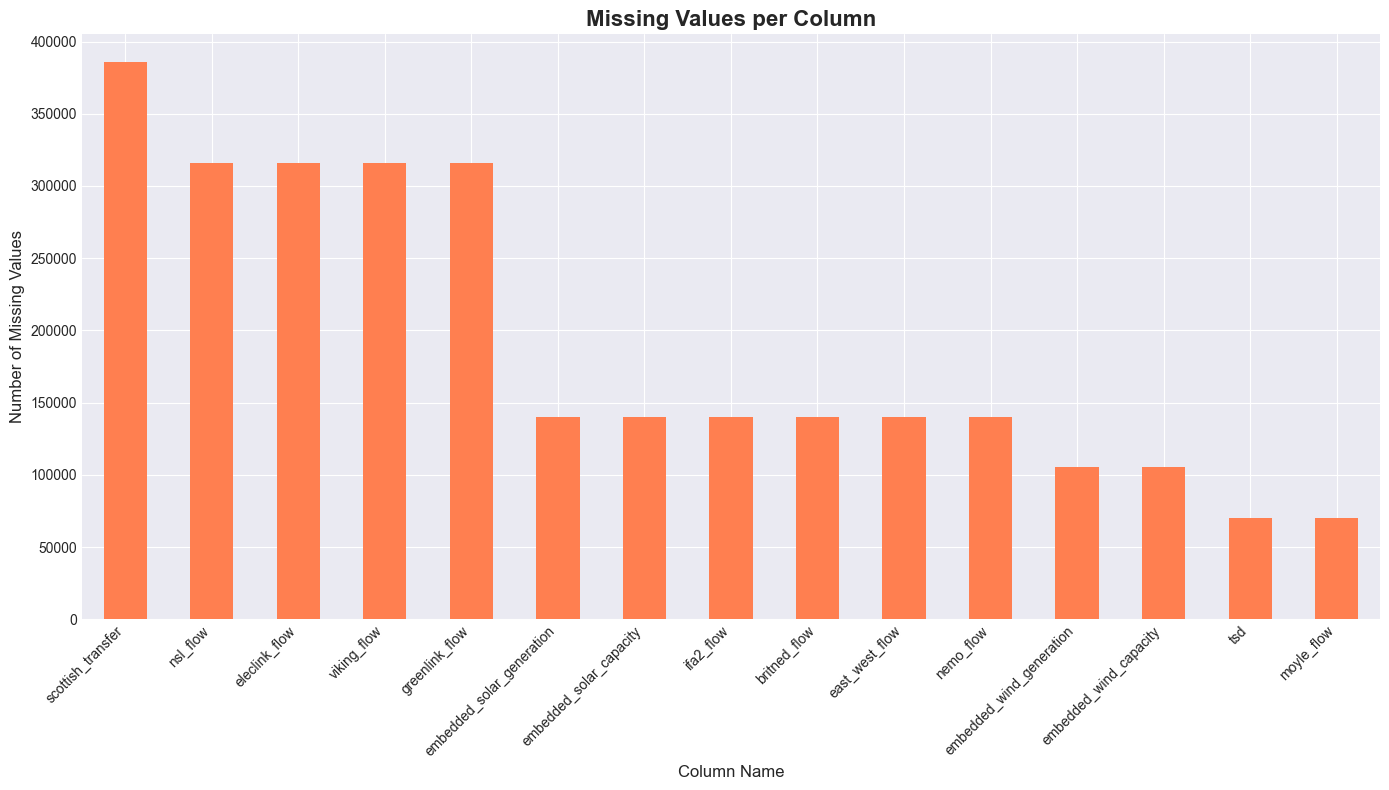

In [11]:
# Visualize missing data
plt.figure(figsize=(14, 8))
missing_cols = missing_df['Column'].tolist()
missing_data = df[missing_cols].isnull().sum()

missing_data.sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Missing Values per Column', fontsize=16, fontweight='bold')
plt.xlabel('Column Name', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Let's check missing values per year
for year in df['year'].unique():
    year_df = df[df['year'] == year]
    missing_count = year_df.isnull().sum().sum()
    print(f"Year {year}: {missing_count} total missing values")

Year 2001: 262800 total missing values
Year 2002: 262800 total missing values
Year 2003: 262800 total missing values
Year 2004: 263520 total missing values
Year 2005: 227760 total missing values
Year 2006: 227760 total missing values
Year 2007: 192720 total missing values
Year 2008: 193248 total missing values
Year 2009: 87600 total missing values
Year 2010: 87600 total missing values
Year 2011: 87600 total missing values
Year 2012: 87840 total missing values
Year 2013: 87600 total missing values
Year 2014: 87600 total missing values
Year 2015: 87600 total missing values
Year 2016: 87840 total missing values
Year 2017: 87600 total missing values
Year 2018: 87600 total missing values
Year 2019: 17520 total missing values
Year 2020: 17568 total missing values
Year 2021: 17520 total missing values
Year 2022: 17520 total missing values
Year 2023: 0 total missing values
Year 2024: 0 total missing values
Year 2025: 0 total missing values


Hier zien we dat de totaal aantal missing values vrij hoog zat in 2001 maar naarmate de jaren zien we de totaal steeds meer dalen omdat de installaties dan geïnstalleerd werden. Vanaf 2023 zien we geen missing values meer.

### 3.4 Missing Values

In [15]:
# Vul met 0 (logisch voor nieuwe interconnectors die nog niet bestonden)
df_clean = df.copy()
df_clean = df_clean.fillna(0)

print("✅ Missing values na opvullen met 0:", df_clean.isnull().sum().sum())

✅ Missing values na opvullen met 0: 0


### 3.5 Outliers Detection

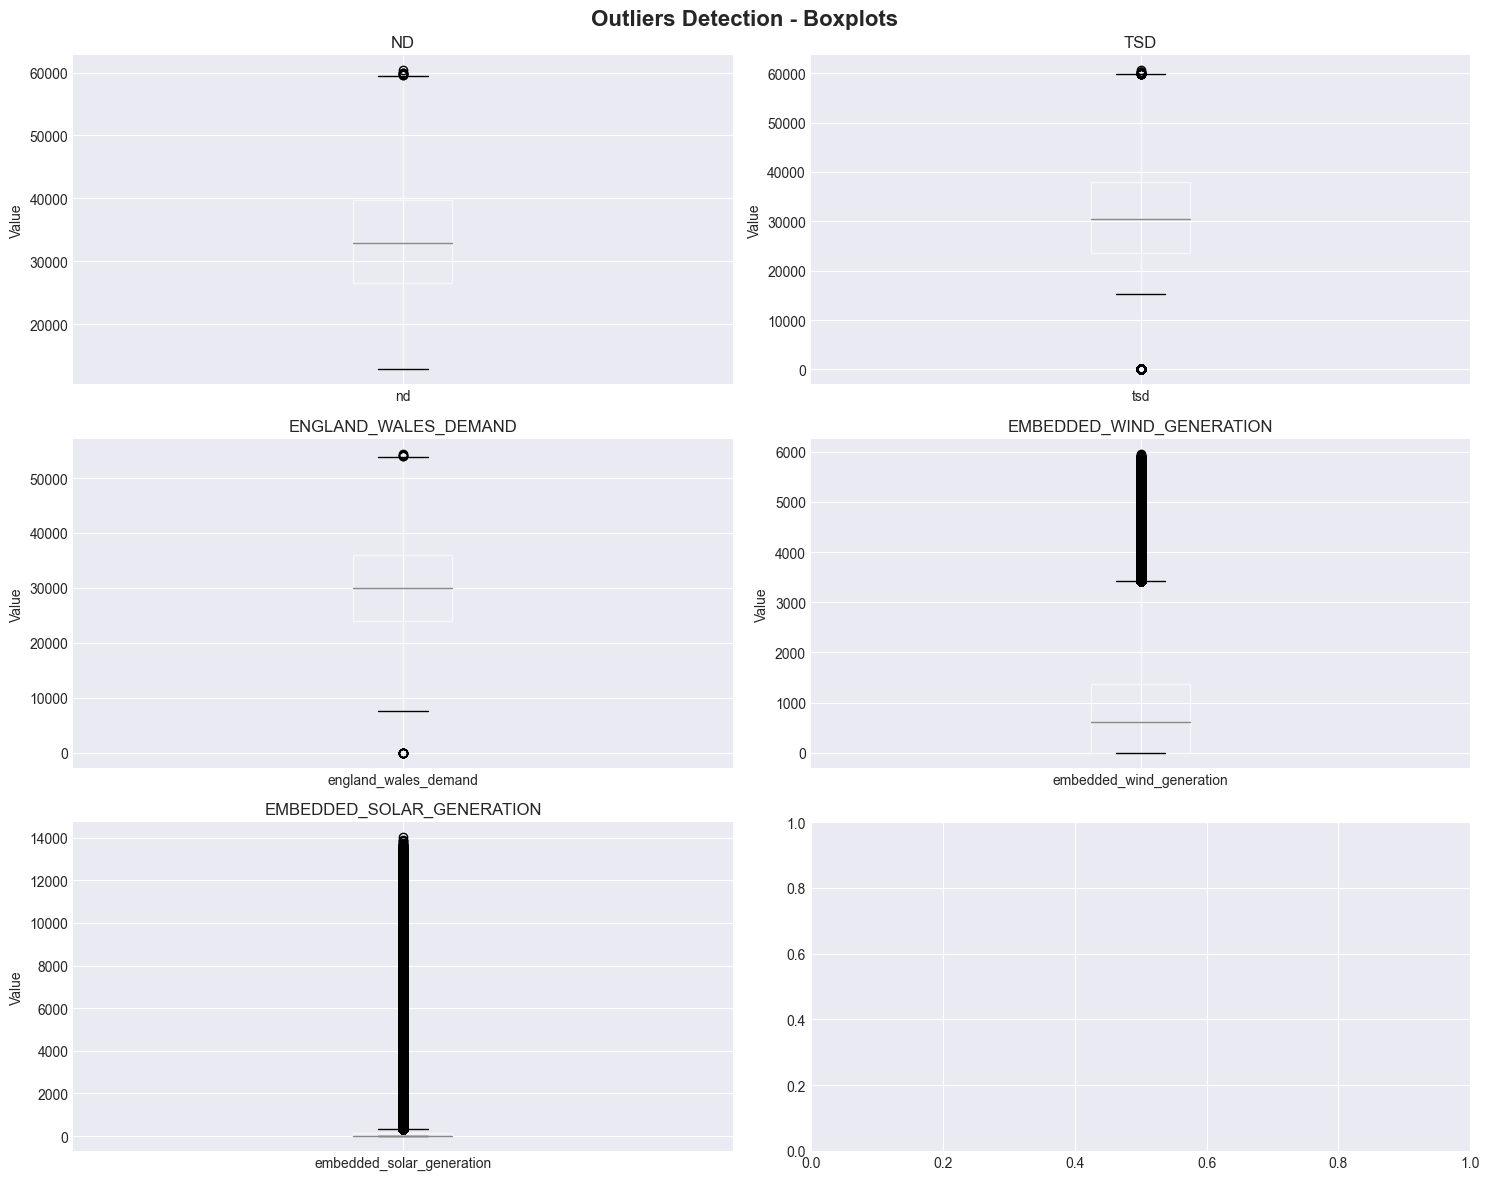

In [ ]:
# Selecteer belangrijke numerieke kolommen
key_columns = ['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 
               'embedded_solar_generation']

# Boxplots om outliers te visualiseren
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Outliers Detection - Boxplots', fontsize=16, fontweight='bold')

for idx, col in enumerate(key_columns):
    ax = axes[idx // 2, idx % 2]
    df_clean.boxplot(column=col, ax=ax)
    ax.set_title(col.upper())
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

Bij ND zitten de waarden tussen de 15.000 en 35.000 MW, sommige waarden liggen boven de 60.000 MK. Waarschijnlijk meetfouten of extreme omstandigheden. TSD loopt van 0 tot 60.000 MW met een paar uitschieters boven 60.000 MW. ENGLAND_WALES_DEMAND vergelijkbaar met ND omdat dit eigenlijk helemaal overeenkomt met elkaar (Engeland + Wales zonder Schotland = ND). EMBEDDED_WIND_GENERATION heeft een grote spreiding met veel variatie, we hebben veel waarden boven het normale bereik dat uitschieters zijn. Waarschijnlijk door invullingswaarden na missing-handling of extreme weersituaties. EMBEDDED_SOLAR_GENERATION heeft al een groter bereik dan de WIND GENERATION met veel uitschieters boven de 500MW. Dit duidt wel op een data-kwaliteitsprobleem.

In [17]:
# IQR method voor outlier detection
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

# Check outliers voor key columns
print("🔍 Outlier Analysis (IQR Method):\n")
for col in key_columns:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    print(f"{col.upper()}:")
    print(f"  - Bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  - Outliers found: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
    print()

🔍 Outlier Analysis (IQR Method):

ND:
  - Bounds: [6684.50, 59496.50]
  - Outliers found: 7 (0.00%)

TSD:
  - Bounds: [1842.12, 59765.12]
  - Outliers found: 74941 (17.27%)

ENGLAND_WALES_DEMAND:
  - Bounds: [6139.88, 53934.88]
  - Outliers found: 15 (0.00%)

EMBEDDED_WIND_GENERATION:
  - Bounds: [-2049.00, 3415.00]
  - Outliers found: 16481 (3.80%)

EMBEDDED_SOLAR_GENERATION:
  - Bounds: [-190.50, 317.50]
  - Outliers found: 96877 (22.32%)



Uit de analyse bleek dat er een aanzienlijke hoeveelheid aan outliers aanwezig was in de dataset TSD, met een totaal van 74941 waarden of 17,27% van de data. Andere datasets zoals ENGLAND_WALES_DEMAND en EMBEDDED_SOLAR_GENERATION hadden ook een aantal outliers, terwijl ND slechts zeven outliers had. Dit geeft aan dat TSD en EMBEDDED_SOLAR_GENERATION een speciale aandacht vraagt om te garanderen dat deze waarden niet de statistieken verstoren.

### 3.6 Categoricals

In [18]:
# Onze categoricals zijn eigenlijk time-based features
# Deze kunnen we labelen als categorisch

categorical_features = ['month', 'dayofweek', 'hour', 'quarter', 'settlement_period']

for col in categorical_features:
    df_clean[col] = df_clean[col].astype('category')

print("✅ Categorical features:")
print(df_clean[categorical_features].dtypes)

✅ Categorical features:
month                category
dayofweek            category
hour                 category
quarter              category
settlement_period    category
dtype: object


In [19]:
# Create readable labels voor dayofweek
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_clean['day_name'] = df_clean['dayofweek'].map(day_names)

# Is weekend?
df_clean['is_weekend'] = df_clean['dayofweek'].isin([5, 6]).astype(int)

print("✅ Extra features created:")
print(df_clean[['dayofweek', 'day_name', 'is_weekend']].head(10))

✅ Extra features created:
  dayofweek day_name  is_weekend
0         0   Monday           0
1         0   Monday           0
2         0   Monday           0
3         0   Monday           0
4         0   Monday           0
5         0   Monday           0
6         0   Monday           0
7         0   Monday           0
8         0   Monday           0
9         0   Monday           0


## 4. Exploratory Data Analysis (EDA)

Nu gaan we de data echt verkennen!

### 4.1 Time Series Visualizations

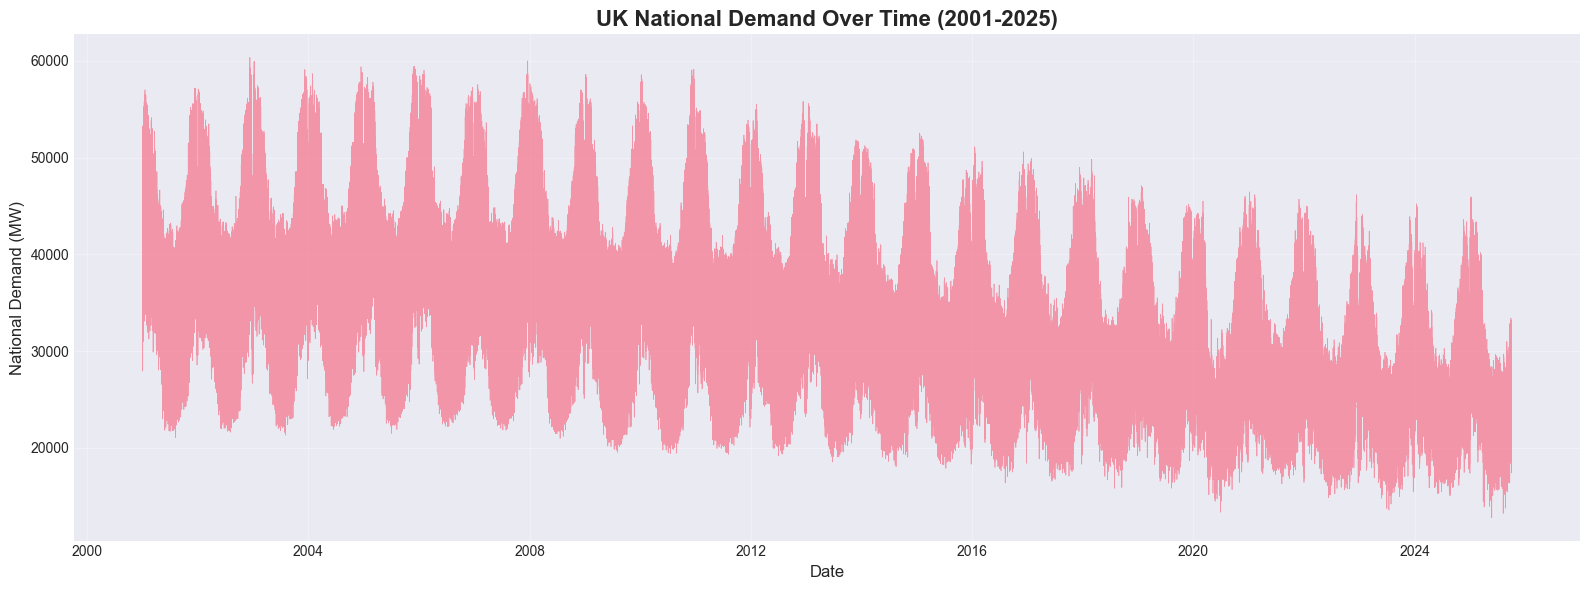

In [20]:
# Plot demand over time
plt.figure(figsize=(16, 6))
plt.plot(df_clean['settlement_date'], df_clean['nd'], linewidth=0.5, alpha=0.7)
plt.title('UK National Demand Over Time (2001-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('National Demand (MW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Bij deze grafiek zien we degelijk een trend per jaar maar ook doorheen de jaren. Het demand per jaar schiet telkens uit in de winter en daalt helemaal weer in de zomer. En dit gebeurt elk jaar opnieuw. Terwijl als we kijken naar de trend doroheen de jaren zien we dat de algemene ND eigenlijk steeds meer daalt! Dit kan natuurlijk door nieuwe normen zijn voor minder verbruik te hebben en slimmere en milieu vriendelijkere apparaten te hebben.

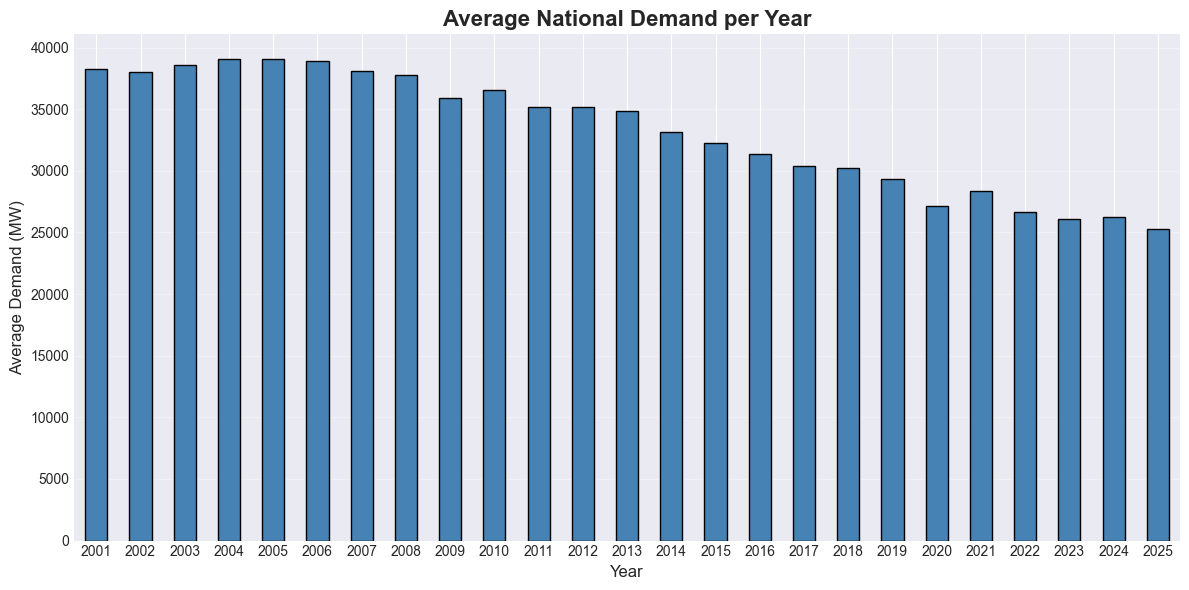

📊 Yearly statistics:
year
2001    38219.949144
2002    38046.114612
2003    38579.868550
2004    39033.015824
2005    39104.252283
2006    38928.612158
2007    38100.511358
2008    37787.268955
2009    35918.631792
2010    36534.875400
2011    35149.928311
2012    35181.259506
2013    34884.623174
2014    33169.309532
2015    32223.340126
2016    31375.304645
2017    30373.098687
2018    30246.766667
2019    29357.640354
2020    27156.527607
2021    28345.294578
2022    26622.288984
2023    26051.745205
2024    26286.762978
2025    25258.307716
Name: nd, dtype: float64


In [21]:
# Yearly averages
yearly_avg = df_clean.groupby('year')['nd'].mean()

plt.figure(figsize=(12, 6))
yearly_avg.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Average National Demand per Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Yearly statistics:")
print(yearly_avg)

Hier zien we duidelijk de nationale demand doorheen de jaren dalen.

### 4.2 Seasonal Patterns

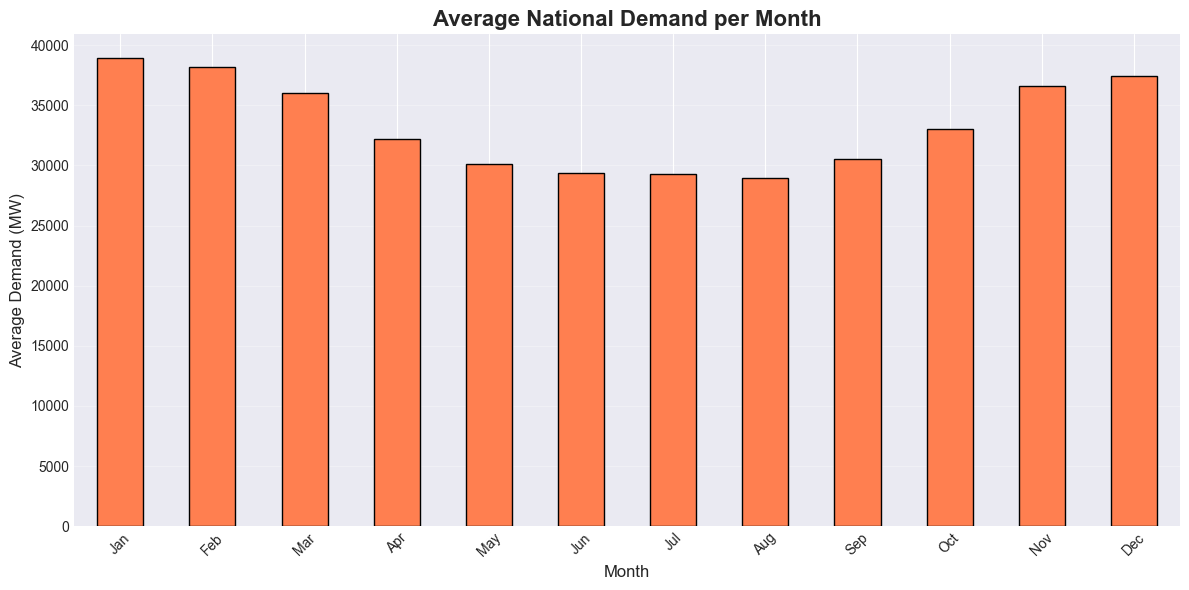

In [22]:
# Monthly patterns
monthly_avg = df_clean.groupby('month')['nd'].mean()

plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average National Demand per Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Zoals we eerder vermelde zien we dat de demand van elektriciteit in zomer maanden veel lager zitten dan die van de winter maanden. Dit is ook logisch want mensen proberen ook hun huis op te warmen en/of meer licht aan te steken. Er is ook minder zon om energie op te wekken dus er zal meer verbruikt worden.

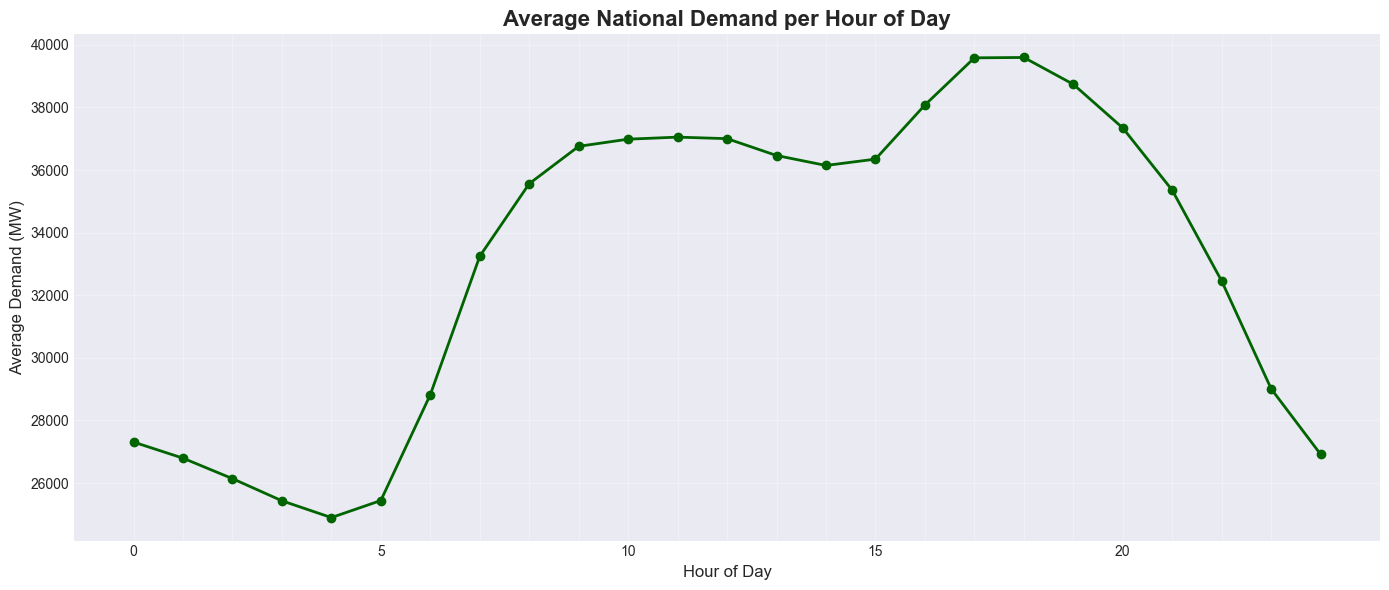

In [23]:
# Daily patterns (hour of day)
hourly_avg = df_clean.groupby('hour')['nd'].mean()

plt.figure(figsize=(14, 6))
hourly_avg.plot(kind='line', marker='o', color='darkgreen', linewidth=2, markersize=6)
plt.title('Average National Demand per Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In deze grafiek zien we de average demand per uur doorheen de dag. Als gewoonlijk zien we dat het energieverbruik laag ligt tijdens de nacht en in de late avond. In de ochtend neemt het energieverbruik vrij snel toe en stabiliseert het rond 10u - 11u. We hebben een kleine dip rond 14u maar daarna neemt de energie weer snel toe. Hoogst waarschijnlijk omdat iedereen terug naar huis komt van school/werk om het huis weer op te warmen bijvoorbeeld. Het laagste punt bevindt zich rond 4u snachts.

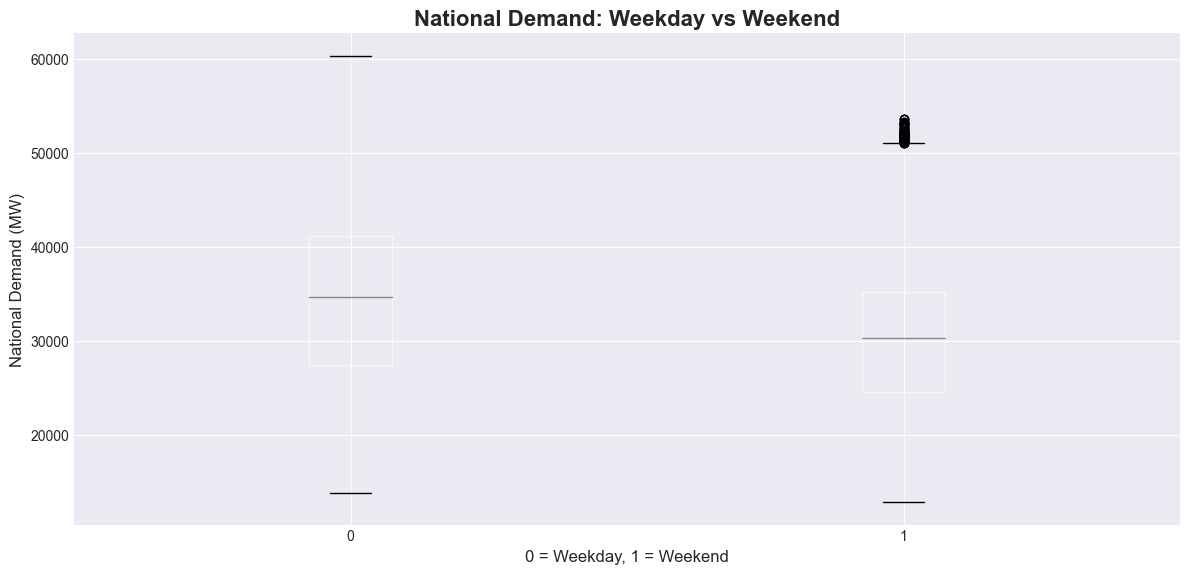

Weekday average: 34599.04 MW
Weekend average: 30246.17 MW
Difference: 4352.87 MW (12.6%)


In [24]:
# Weekend vs Weekday
plt.figure(figsize=(12, 6))
df_clean.boxplot(column='nd', by='is_weekend', ax=plt.gca())
plt.title('National Demand: Weekday vs Weekend', fontsize=16, fontweight='bold')
plt.suptitle('')  # Remove automatic title
plt.xlabel('0 = Weekday, 1 = Weekend', fontsize=12)
plt.ylabel('National Demand (MW)', fontsize=12)
plt.tight_layout()
plt.show()

weekday_avg = df_clean[df_clean['is_weekend'] == 0]['nd'].mean()
weekend_avg = df_clean[df_clean['is_weekend'] == 1]['nd'].mean()

print(f"Weekday average: {weekday_avg:.2f} MW")
print(f"Weekend average: {weekend_avg:.2f} MW")
print(f"Difference: {weekday_avg - weekend_avg:.2f} MW ({(weekday_avg-weekend_avg)/weekday_avg*100:.1f}%)")

Hier laten we het gebruik per weekdag en weekend zien en vergelijken ze via boxplots. We zien dat het gemiddelde van de weekends lager zit dan die van de weekdagen! We hebben ook outliers bij het weekend maar deze komen niet hoger dan die van de weekdagen. Dit kan waarschijnlijk komen door al de mensen die niet op school/werk moeten zijn en waarbij grotere gebouwen minder energie moeten hebben om op te warmen of andere materialen elektriciteit te geven. 

### 4.3 Renewable Energy Evolution

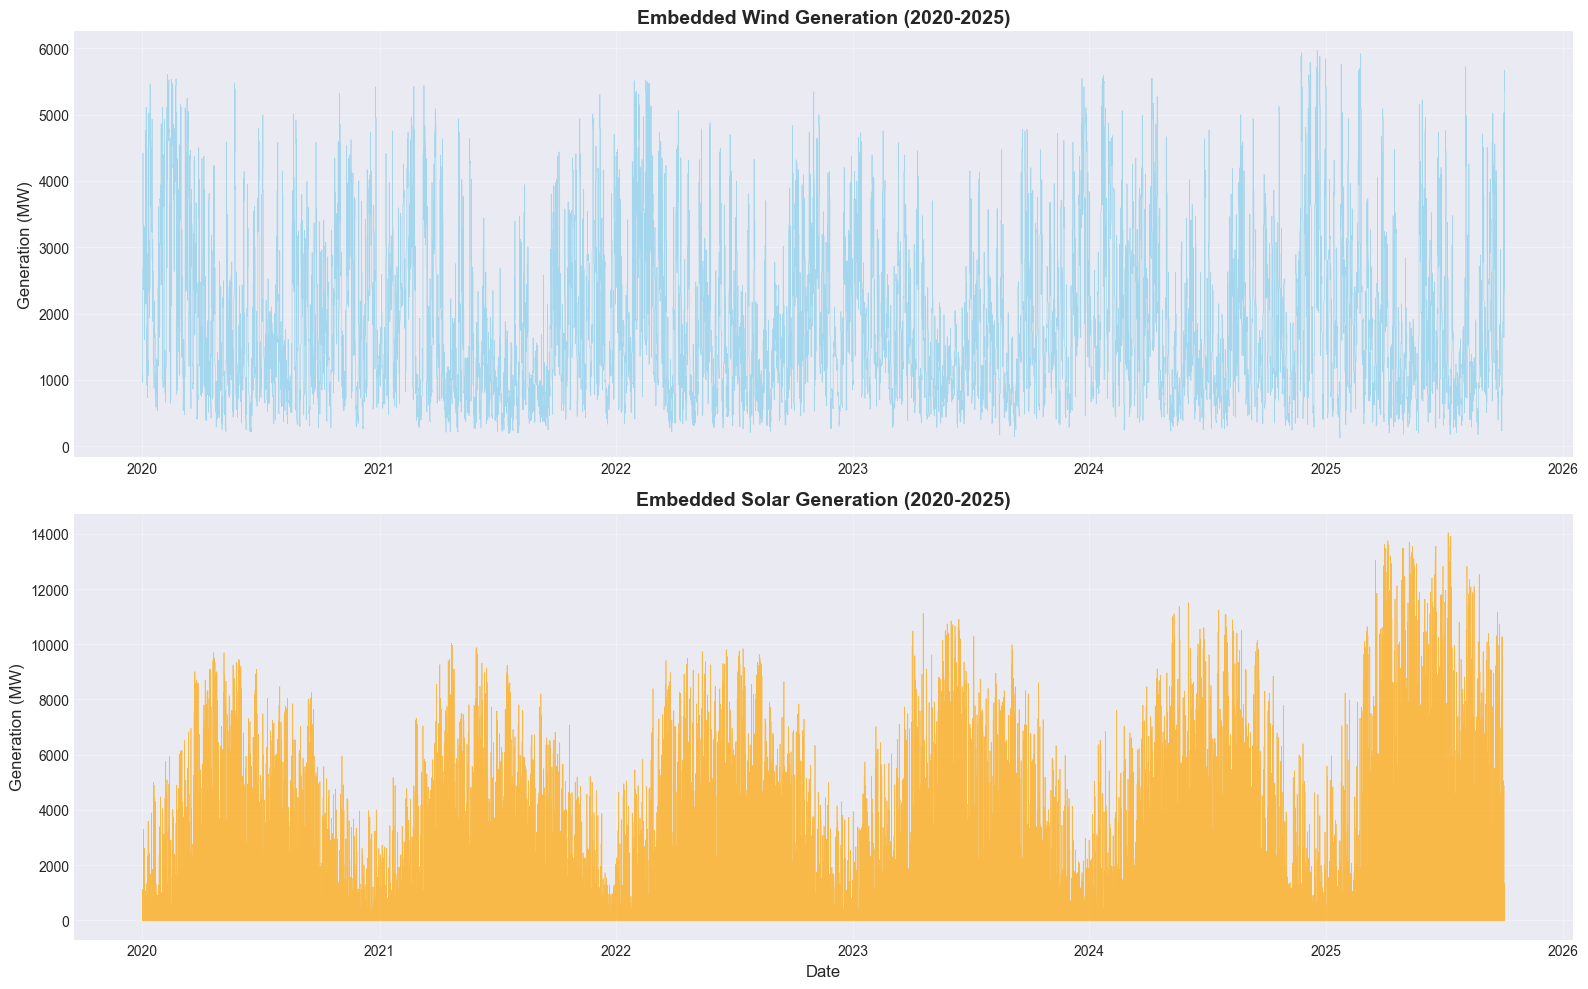

In [25]:
# Wind and solar generation over time
# Only use years where we have data
renewable_df = df_clean[df_clean['year'] >= 2020].copy()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Wind
axes[0].plot(renewable_df['settlement_date'], renewable_df['embedded_wind_generation'], 
             linewidth=0.5, alpha=0.7, color='skyblue')
axes[0].set_title('Embedded Wind Generation (2020-2025)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Generation (MW)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Solar
axes[1].plot(renewable_df['settlement_date'], renewable_df['embedded_solar_generation'], 
             linewidth=0.5, alpha=0.7, color='orange')
axes[1].set_title('Embedded Solar Generation (2020-2025)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Generation (MW)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In deze grafiek nemen we alleen de laatste 5 jaren omdat wind generatoren en zonnepanelen niet ver in het verleden zijn ontwikkeld dus ook nog niet veel werden gebruikt toen. In onze wind generation zien we overduidelijk dat er geen duidelijk toename of afname is. Maar in de solar generation zien we een seizoensgebonden trend zoals we eerder zagen. Maar ook zien we hier dat over de jaren heen dat er steeds meer en meer solar generation power is! Dit kan natuurlijk komen dat veel meer mensen zonnepanelen kopen en laten installeren op hun huis. In 2025 zien we een groot verschil tussen de andere voorige jaren. 

### 4.4 Correlation Analysis

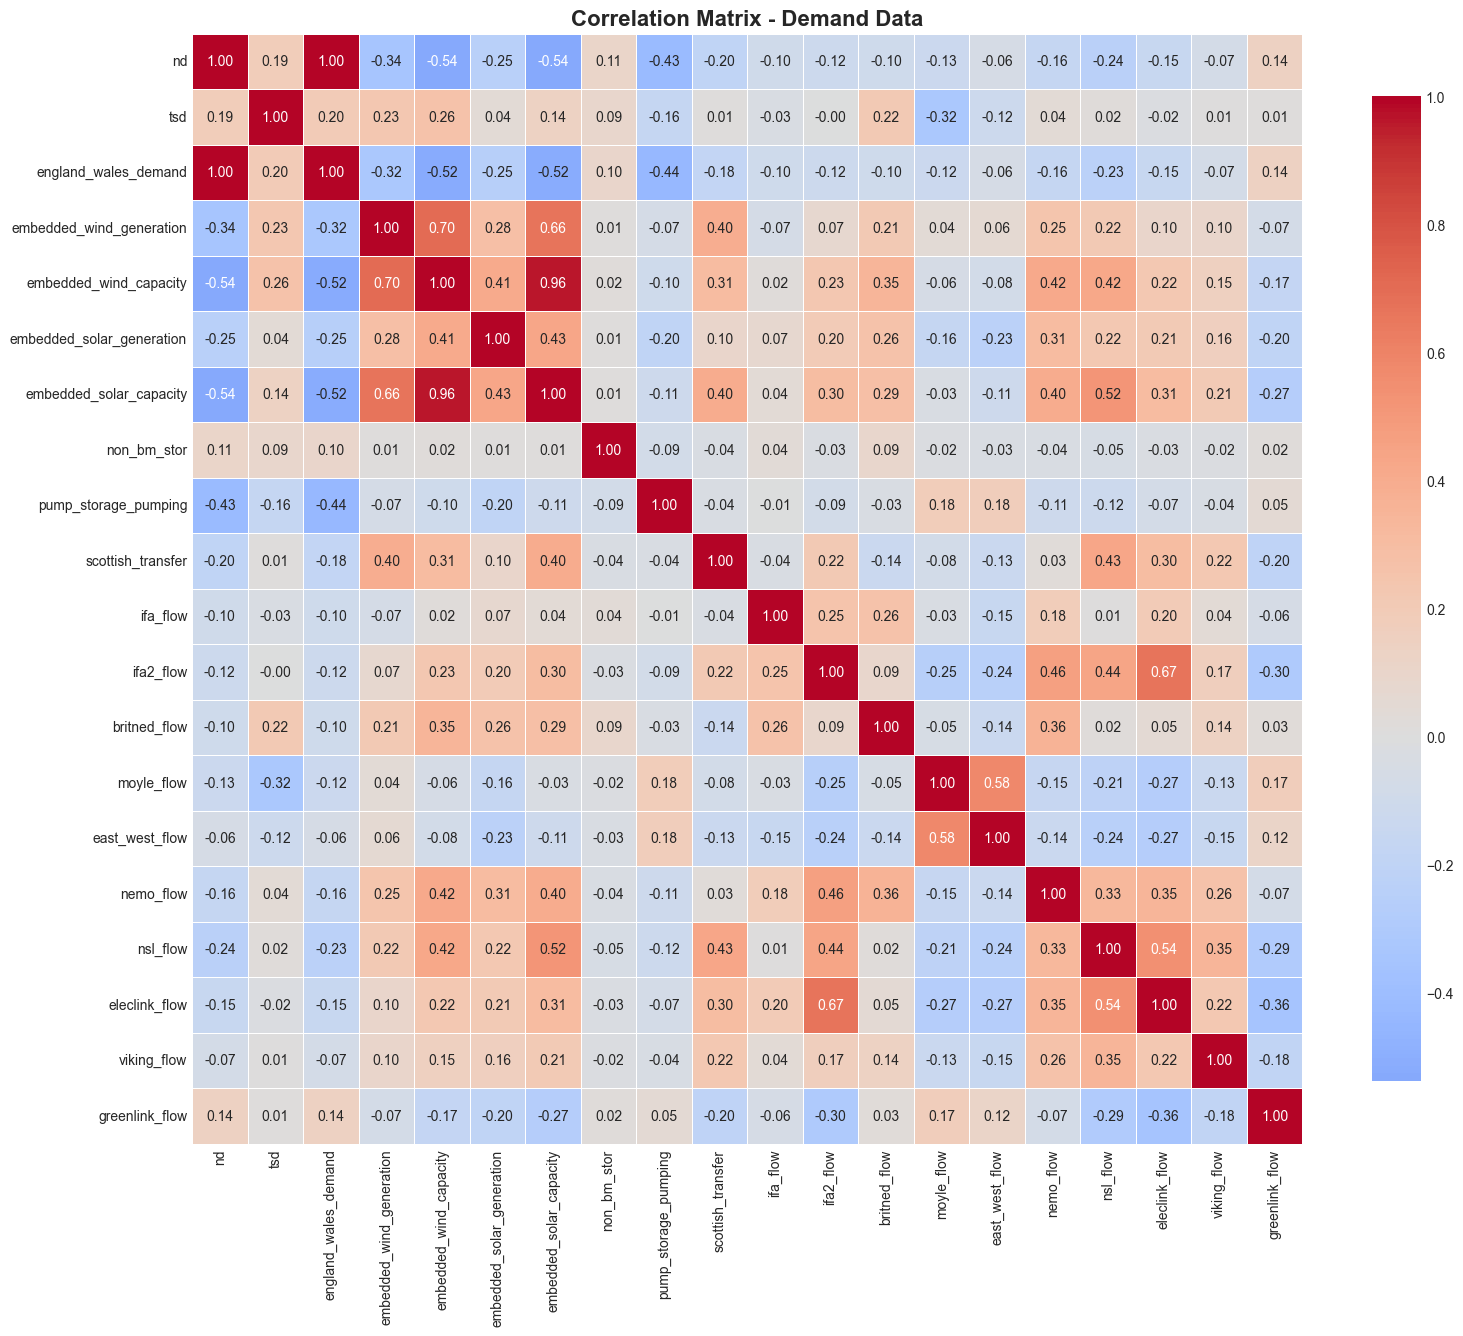

In [26]:
# Select numeric columns voor correlatie
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Remove date-related integer columns
cols_to_exclude = ['year', 'month', 'day', 'dayofweek', 'quarter', 'week', 
                   'settlement_period', 'hour', 'is_weekend']
correlation_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Calculate correlation matrix
corr_matrix = df_clean[correlation_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Demand Data', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In deze correlatie matrix zien we overduidelijk een grote correlatie (1.0) van ND en england_wales_demand. Deze zijn eigenlijk terecht want deze beiden demands komen eigenlijk overeen met elkaar. england en wales = national demand. Dus waarom deze twee apart??

In [27]:
# Find highest correlations with ND (National Demand)
nd_correlations = corr_matrix['nd'].sort_values(ascending=False)

print("🔍 Highest correlations with National Demand:\n")
print(nd_correlations.head(10))

🔍 Highest correlations with National Demand:

nd                      1.000000
england_wales_demand    0.998893
tsd                     0.186781
greenlink_flow          0.142733
non_bm_stor             0.106266
east_west_flow         -0.058059
viking_flow            -0.072134
ifa_flow               -0.095246
britned_flow           -0.103370
ifa2_flow              -0.122789
Name: nd, dtype: float64


### 4.5 Interesting Findings & Graphs

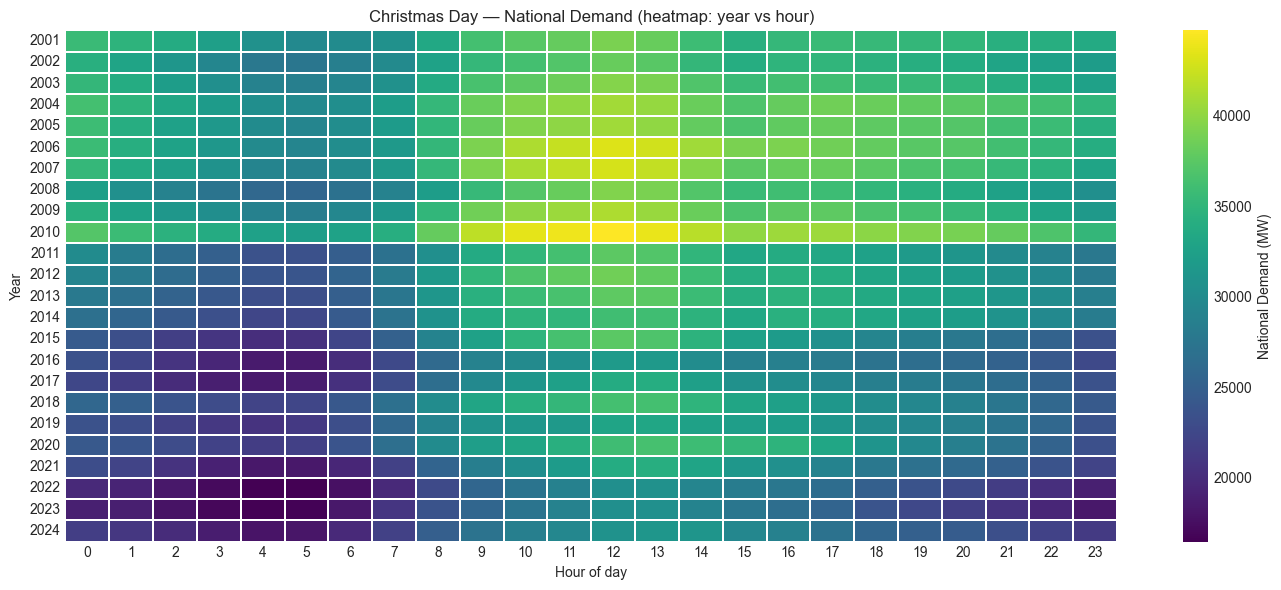

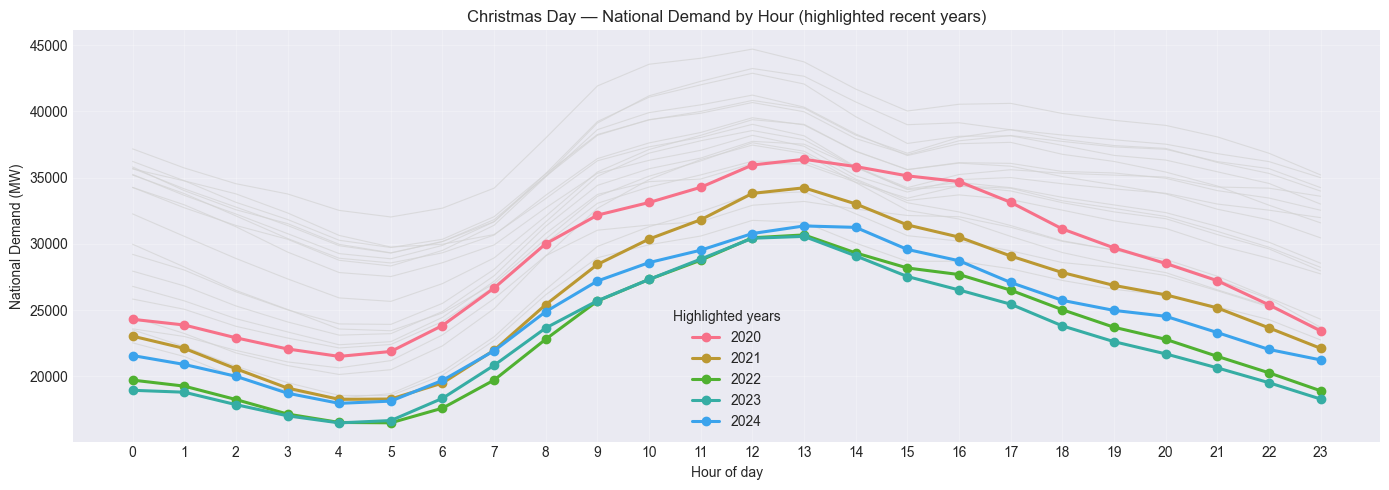

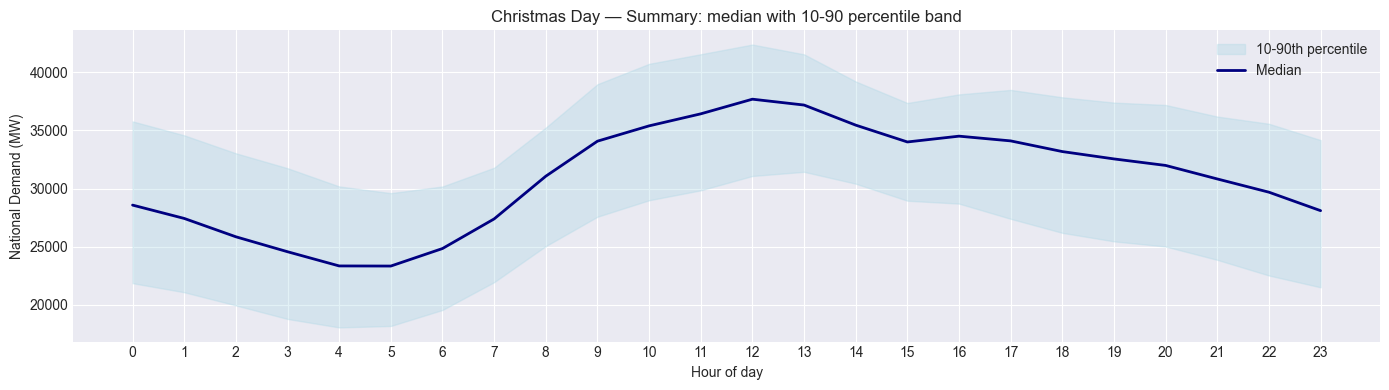

Plotted years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [28]:
# Improved Christmas-day overview: heatmap + focused lineplot + summary band
christmas_data = df_clean[(df_clean['month'] == 12) & (df_clean['day'] == 25)].copy()
if christmas_data.empty:
    print('Geen Christmas-data gevonden in df_clean.')
else:
    # Pivot so rows=hour, cols=year -> easier plotting and aggregation if duplicates exist
    pivot = christmas_data.pivot_table(index='hour', columns='year', values='nd', aggfunc='mean')
    # ensure hours 0-23 present (some datasets might use 0-23 or 1-24)
    pivot = pivot.reindex(range(0, 24)).sort_index()
    years = pivot.columns.sort_values()

    # 1) Heatmap: years vs hours (transpose so years are rows -> readable y-axis)
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot.T, cmap='viridis', cbar_kws={'label': 'National Demand (MW)'}, linewidths=0.25)
    plt.title('Christmas Day — National Demand (heatmap: year vs hour)')
    plt.xlabel('Hour of day')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()

    # 2) Lineplot: plot all years faint + highlight recent years for clear legend
    highlight = list(years[-5:]) if len(years) >= 5 else list(years)
    plt.figure(figsize=(14, 5))
    for y in years:
        series = pivot[y]
        if y in highlight:
            plt.plot(series.index, series.values, marker='o', label=str(y), linewidth=2.2)
        else:
            # faint background lines without legend entries
            plt.plot(series.index, series.values, color='lightgray', linewidth=0.8, alpha=0.7)
    plt.title('Christmas Day — National Demand by Hour (highlighted recent years)')
    plt.xlabel('Hour of day')
    plt.ylabel('National Demand (MW)')
    plt.xticks(range(0, 24))
    plt.legend(title='Highlighted years')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 3) Summary: median with 10-90 percentile band to quickly see spread
    plt.figure(figsize=(14, 4))
    median = pivot.median(axis=1)
    p10 = pivot.quantile(0.10, axis=1)
    p90 = pivot.quantile(0.90, axis=1)
    plt.fill_between(median.index, p10, p90, color='lightblue', alpha=0.35, label='10-90th percentile')
    plt.plot(median.index, median.values, color='navy', label='Median', linewidth=2)
    plt.title('Christmas Day — Summary: median with 10-90 percentile band')
    plt.xlabel('Hour of day')
    plt.ylabel('National Demand (MW)')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'Plotted years: {list(years)}')

Deze grafieken tonen het elektriciteitsverbruik in het VK op kerstdag over meerdere jaren. De heatmap (afbeelding 1) laat zien dat de vraag typisch laag is in de vroege ochtend (uur 4-6) en piekt rond het middaguur (12-13u), met een duidelijke trend van afnemende totale vraag in recentere jaren (2015-2024 zijn donkerder blauw). De tweede grafiek bevestigt dit patroon voor 2020-2024 met een karakteristieke dip 's ochtends wanneer mensen slapen, gevolgd door een sterke stijging wanneer iedereen het kerstdiner voorbereidt, waarna de vraag geleidelijk daalt tijdens de avond.

## 5. Data Export voor Modeling

Nu we de data hebben schoongemaakt, slaan we het op voor de volgende stap.

In [29]:
# Check final dataframe
print("✅ Final cleaned dataframe:")
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"\nData types:")
print(df_clean.dtypes)

✅ Final cleaned dataframe:
Shape: (434014, 31)
Missing values: 0

Data types:
settlement_date              datetime64[ns]
settlement_period                  category
nd                                    int64
tsd                                 float64
england_wales_demand                  int64
embedded_wind_generation            float64
embedded_wind_capacity              float64
embedded_solar_generation           float64
embedded_solar_capacity             float64
non_bm_stor                           int64
pump_storage_pumping                  int64
scottish_transfer                   float64
ifa_flow                              int64
ifa2_flow                           float64
britned_flow                        float64
moyle_flow                          float64
east_west_flow                      float64
nemo_flow                           float64
nsl_flow                            float64
eleclink_flow                       float64
viking_flow                         float6

In [30]:
# Save cleaned data
output_path = '../data/processed/'
df_clean.to_csv(f'{output_path}demand_data_cleaned.csv', index=False)

print("✅ Cleaned data ready for modeling!")

✅ Cleaned data ready for modeling!
